In [1]:
cd IMGS-789-Advanced-Robust-ML-for-Interdisciplinary-Imaging-Science-Applications/group_project/

[Errno 2] No such file or directory: 'IMGS-789-Advanced-Robust-ML-for-Interdisciplinary-Imaging-Science-Applications/group_project/'
/home/ckb2084/research/IMGS-789-Advanced-Robust-ML-for-Interdisciplinary-Imaging-Science-Applications/group_project


/home/ckb2084/conda/envs/pytorch/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


## Loading in nesscary pacakges 

In [2]:
# Neccesary imports
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from time import time
import random
import glob, os

from sklearn.model_selection import train_test_split

# from scipy.ndimage.filters import gaussian_filter1d
# import torchvision.models as models
# from tqdm import tqdm
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt
# from accelerate import Accelerator
# cm = plt.get_cmap('RdYlBu')
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torch.nn import LayerNorm
# import math
# from sklearn.model_selection import train_test_split
# import seaborn as sns
# import matplotlib.colors as mcolors
# import pandas as pd

# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# from scipy.stats import gaussian_kde

## Reading in both spectrun and photomteric data

In [6]:
%%time
# Import all the data
data = pd.read_pickle('grism_specPT.pkl')
data_sed = pd.read_pickle('sed_fitting.pkl')


data_sed_chi_l5 = data_sed[data_sed['best.reduced_chi_square'] <= 10.0]
data_sed_chi_l5.reset_index(drop=True, inplace=True)
id = [int(i) for i in data_sed_chi_l5['id']]

# pulling only datapoints with a SNR at or above 2.5 and a redshift below 1.7
data = data[data['SNR']>=2.5]
data_subset = data[data['z']<1.7]
data_subset = data_subset.iloc[id]
data_subset.reset_index(drop=True, inplace=True)

data_subset.head()

CPU times: user 1.4 s, sys: 1.05 s, total: 2.45 s
Wall time: 2.46 s


,grism_id,wavelength,flux,z,SNR,continuum_sub_flux
0,aegis-17-G141_30965,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.38,3.489914,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,aegis-27-G141_30932,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.99,21.690476,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,aegis-05-G141_30995,"[10208.409432389317, 10209.33721533346, 10210....","[0.01701213071057106, 0.016043157870794716, 0....",1.33,18.965318,"[0.013735106802129587, 0.01274948884085334, 0...."
3,aegis-05-G141_31123,"[10208.409432389317, 10209.33721533346, 10210....","[0.07342653922120977, 0.07218629979937985, 0.0...",0.93,4.359223,"[0.0725253907911552, 0.07128149956720402, 0.07..."
4,aegis-17-G141_31172,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.05,9.725275,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Doing a train,val and test split on the data

In [ ]:


# Split the data into 70% train and 30% temp_test
train_df, temp_test_df = train_test_split(data_subset, test_size=0.3, random_state=42)

# Split the temp_test into 50% test and 50% validation, which is 15% each of the original
test_df, val_df = train_test_split(temp_test_df, test_size=0.5, random_state=42)

train_additional_data = data_sed_chi_l5.loc[train_df.index]
test_additional_data = data_sed_chi_l5.loc[test_df.index]
val_additional_data = data_sed_chi_l5.loc[val_df.index]

# Print the sizes of each set
print(f'Train set size: {len(train_df)}')
print(f'Validation set size: {len(test_df)}')
print(f'Test set size: {len(val_df)}')

## Loading in SpecPT and Redshift Model

In [8]:
from SpecPT import (
    SpecPT, 
    SpecPTForRedshift, 
    CustomLoadDataset_Autoencoder,
    Swish,
    # CustomLoadDataset_Redshift, 
    NMADLoss, 
    evaluate
)

In [9]:
class EnhancedSpecPTForRedshift(nn.Module):
    def __init__(self, pretrained_model, additional_features_dim, output_features=1, num_mlp_blocks=5, mlp_dim=512, dropout_rate=0.2):
        super(EnhancedSpecPTForRedshift, self).__init__()
        
        self.encoder = pretrained_model.transformer_encoder
        self.proj_to_d_model = pretrained_model.proj_to_d_model
        self.forward_conv = pretrained_model.forward_conv
        
        # Fine-tune the last few layers of the encoder
        for param in list(self.encoder.parameters())[-4:]:
            param.requires_grad = True
        
        # Projection layer for additional features
        self.additional_projection = nn.Sequential(
            nn.Linear(additional_features_dim, 512),
            # nn.LayerNorm(512),
            Swish(),
            nn.Dropout(dropout_rate),
            nn.LayerNorm(512)
        )
        self.additional_bn = nn.BatchNorm1d(512)
        
        # Early fusion layer before attention
        self.pre_attention_fusion = nn.Sequential(
            # nn.LayerNorm(1024),
            nn.Linear(1024, 512),
            Swish(),
            nn.Linear(512, 512),
            Swish(),
            nn.Dropout(dropout_rate),
            nn.LayerNorm(512)
        )
        
        self.attention = nn.MultiheadAttention(embed_dim=512, num_heads=8,dropout=dropout_rate)
        # self.gradient_clip = 1.0
        self.flatten = nn.Flatten(1)
        self.mlp_blocks = nn.Sequential(
            *[ImprovedResidualMLPBlock(mlp_dim if i > 0 else 512, mlp_dim, dropout_rate) for i in range(num_mlp_blocks)]
        )
        
        self.prediction = nn.Sequential(
            nn.Linear(mlp_dim, mlp_dim // 2),
            Swish(),
            nn.Dropout(dropout_rate),
            nn.Linear(mlp_dim // 2, output_features),
            nn.Softplus()
        )
        
    def forward(self, x, additional_data):
        batch_size = x.size(0)
        
        # Process spectral data
        x = x.unsqueeze(1)
        # print(x.shape)
        x = self.forward_conv(x)
        # print(x.shape)

        # Flatten and project
        x = self.flatten(x)  # Flatten all dimensions except batch
        # print(x.shape)
        x = self.proj_to_d_model(x)
        # print(x.shape)
        x = x.view(batch_size, -1, 512)  # Reshape to (batch_size, seq_len, features)
        # print(x.shape)
        
        # Encode spectral features
        encoded_features = self.encoder(x.transpose(0, 1))  # (seq_len, batch_size, features)
        # print(encoded_features.shape)
        encoded_features = encoded_features.transpose(0, 1)  # (batch_size, seq_len, features)
        # print(encoded_features.shape)
        
        # Process additional data
        # print(additional_data.shape)
        additional_features = self.additional_projection(additional_data)
        # additional_features = self.additional_bn(additional_features)
        # print(f'additional_features : {additional_features.shape}')
        additional_features = additional_features.unsqueeze(1)  # Add sequence dimension
        # print(additional_features.shape)
        
        # Combine features
        combined_features = torch.cat([encoded_features, additional_features], dim=-1)
        # print(combined_features.shape)
        fused_features = self.pre_attention_fusion(combined_features)
        # print(fused_features.shape)
        
        # Apply attention
        fused_features = fused_features.transpose(0, 1)  # (seq_len, batch_size, features)
        attn_output, _ = self.attention(fused_features, fused_features, fused_features)
        attn_output = attn_output.transpose(0, 1)  # (batch_size, seq_len, features)
        
        # Residual connection
        x = attn_output + fused_features.transpose(0, 1)
        
        # Process through MLP blocks
        x = self.mlp_blocks(x)
        
        # Final prediction - average over sequence dimension
        x = x.mean(dim=1)
        redshift = self.prediction(x)
        
        return redshift

class ImprovedResidualMLPBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate):
        super(ImprovedResidualMLPBlock, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.swish = Swish()
        self.layer_norm = nn.LayerNorm(output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        residual = x
        x = self.swish(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        x = x + residual  # Residual connection
        x = self.layer_norm(x)
        return self.swish(x)


## Dataset Loader for Redshift

In [10]:

from sklearn.preprocessing import MinMaxScaler
class CustomLoadDataset_Redshift(Dataset):
    def __init__(self, df, additional_data_df):
        x = []
        y = []
        additional_data = []
        target_id = []
            
        for _, row in df.iterrows():
            fl = row['flux']
            if np.median(fl) > 0:
                fl = fl / np.median(fl)
                x.append(fl)
                y.append(np.array([row['z']]))
                # additional_data.append(additional_data_df['flux'].loc[index])
                target_id.append(row['grism_id'])

        for _,row in additional_data_df.iterrows():
            fl_ph = row['flux']
            # if np.median(fl_ph) > 0:
            # fl_ph = fl_ph / np.median(fl_ph)
            scaler = MinMaxScaler(feature_range=(0, 1))
            fl_ph = scaler.fit_transform(fl_ph.reshape(-1, 1)).flatten()
                # x.append(fl_ph)
                # y.append(np.array([row['z']]))
            additional_data.append(fl_ph)
                # target_id.append(row['grism_id'])


        self.X = torch.from_numpy(np.stack(x, axis=0))
        self.Y = torch.from_numpy(np.stack(y, axis=0))
        self.additional_data = torch.from_numpy(np.stack(additional_data, axis=0))
        self.t_id = target_id

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # print(idx)
        # print(self.X[idx].shape)
        # print(self.Y[idx].shape)
        # print(self.additional_data[idx].shape)
        # print(self.t_id[idx])
        return self.X[idx].float(), self.Y[idx].float(), self.additional_data[idx].float(), idx, self.t_id[idx]


## Configurations for the model

In [11]:
config = {
    "input_size": 7781,
    "d_model": 512,
    "nhead": 8,
    "num_encoder_layers": 3,
    "num_decoder_layers": 3,
    "dim_feedforward": 2048,
    "learning_rate": 5e-5,
    "batch_size": 64,  # Reduced batch size
    "num_mlp_blocks": 2,  # increased from 2
    "mlp_dim": 512,
    "dropout_rate": 0.8, ## Changed from 0.8
    "weight_decay": 1e-3  # Added weight decay
}


In [14]:
from accelerate import Accelerator
accelerator = Accelerator()
additional_features_dim = data_sed_chi_l5['flux'][0].shape[0]
model = SpecPT(input_size=7781) #, d_head=16
# model.load_state_dict(torch.load('redshift_prediction_model_1D_large_kernel_staggered_training.pth'))

# Load the model state
# state_dict = torch.load('saved_models/SpecPT_training_HST_150.pth', map_location='cpu')  # Load to CPU first 
file_path = os.path.expanduser('~/research/galax_spec/pretrained_weights')
# state_dict = torch.load(f'{file_path}/SpecPT_DESI_combined_autoencoder_150.pth', map_location='cpu')
state_dict = torch.load(f'{file_path}/SpecPT_training_HST_150.pth', map_location='cpu')

model.load_state_dict(state_dict)
model.to(accelerator.device)
# Initialize the modified SpecPT model for redshift prediction
# redshift_model = SpecPTForRedshift(model)  # `model` is the pretrained SpecPT instance
additional_features_dim = data_sed_chi_l5['flux'][0].shape[0]

redshift_model = EnhancedSpecPTForRedshift(
    model,
    additional_features_dim=additional_features_dim,
    output_features=1, 
    num_mlp_blocks=config["num_mlp_blocks"], 
    mlp_dim=config["mlp_dim"], 
    dropout_rate=config["dropout_rate"],
    # additional_features_dim=additional_features_dim
)

# Load the model state
# state_dict = torch.load('saved_models/SpecPT_HST_redshift_model_DESI_combined_PT_Enhanced_photo'+str(epochs*n)+'.pth', map_location='cpu')  # Load to CPU first
# state_dict = torch.load('pretrained_weights/SpecPT_HST_redshift_model_DESI_combined_PT_Enhanced_'+'500.pth', map_location='cpu')  # Load to CPU first
state_dict = torch.load('saved_models/SpecPT_HST_redshift_model_DESI_combined_PT_Enhanced_photo_best1.pth', map_location='cpu')  # Load to CPU first


redshift_model.load_state_dict(state_dict)
redshift_model = redshift_model.to(accelerator.device)

/tmp/ipykernel_1015801/198150949.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{file_path}/SpecPT_training_HST_150.pth', map_location='cpu')

In [17]:
valid_loader = DataLoader(CustomLoadDataset_Redshift(val_df,val_additional_data), batch_size=64, shuffle=True,drop_last=True)
test_loader = DataLoader(CustomLoadDataset_Redshift(test_df,test_additional_data), batch_size=64, shuffle=True,drop_last=True)
train_loader = DataLoader(CustomLoadDataset_Redshift(train_df,train_additional_data), batch_size=64, shuffle=True,drop_last=True)

## Custom function for Gradcam and visualizing heatmaps

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        """
        Initialize Grad-CAM with the model and the target layer.
        Args:
            model (nn.Module): The neural network model.
            target_layer (nn.Module): The layer to compute Grad-CAM on.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None  # To store gradients of the target layer
        self.activations = None  # To store activations of the target layer

        # Register hooks to capture gradients and activations
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        """
        Hook function to save activations during the forward pass.
        Args:
            module: The layer where the hook is registered.
            input: Input to the layer.
            output: Output from the layer.
        """
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        """
        Hook function to save gradients during backpropagation.
        Args:
            module: The layer where the hook is registered.
            grad_input: Gradients with respect to input.
            grad_output: Gradients with respect to output.
        """
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, target_class=None):
        """
        Generate the Grad-CAM heatmap for a given input tensor and target class.
        Args:
            input_tensor (torch.Tensor): Input tensor to the model.
            target_class (int): Target class index for which to compute Grad-CAM. If None, use the predicted class.

        Returns:
            heatmap (torch.Tensor): The generated Grad-CAM heatmap.
        """
        # Forward pass through the model
        output = self.model(input_tensor)

        # If no target class is specified, use the predicted class
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass to compute gradients of the target class score w.r.t. feature maps
        self.model.zero_grad()
        loss = output[0, target_class]  # Select score of the target class
        # print(loss)
        loss.backward()

        # Get feature maps and gradients from the target layer
        feature_maps = self.activations  # Activations from forward pass
        gradients = self.gradients  # Gradients from backward pass

        # Compute weights by global average pooling over spatial dimensions
        weights = torch.mean(gradients, dim=2)  # Average over width

        # Compute weighted sum of feature maps
        cam = torch.zeros_like(feature_maps[0], dtype=torch.float32)
        for i, w in enumerate(weights[0]):
            cam += w * feature_maps[0, i]

        # Apply ReLU to remove negative values
        cam = F.relu(cam)

        # Normalize CAM to [0, 1]
        cam -= cam.min()
        cam /= cam.max()

        return cam




In [57]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_heatmap(input_tensor, heatmap,target_layer_name):
    """
    Visualize Grad-CAM heatmap overlaid on the input signal.
    Args:
        input_tensor (torch.Tensor): Original input signal (1D tensor).
        heatmap (torch.Tensor): Generated Grad-CAM heatmap (1D tensor).
    """
    # Detach and convert tensors to numpy arrays
    input_signal = input_tensor.squeeze().cpu().numpy()
    heatmap = heatmap.detach().squeeze().cpu().numpy()

    # Ensure both input_signal and heatmap are 1D arrays
    if input_signal.ndim > 1:
        input_signal = input_signal.flatten()
    if heatmap.ndim > 1:
        heatmap = heatmap.flatten()

    # Rescale heatmap to match the length of the input signal if necessary
    if len(heatmap) != len(input_signal):
        heatmap = np.interp(np.arange(len(input_signal)), np.linspace(0, len(input_signal), len(heatmap)), heatmap)
        print(heatmap.shape)

    # Normalize the heatmap for better visualization
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    # Plot the original signal and overlay the Grad-CAM heatmap
    plt.figure(figsize=(12, 6))
    # plt.fill_between(range(len(input_signal)), input_signal * heatmap, alpha=0.5, color="red", label="Grad-CAM Heatmap")

    plt.plot(input_signal, label="Input Signal", color="blue", alpha=0.6)

    plt.imshow(
        heatmap[None, :],  # Reshape heatmap for imshow
        aspect="auto",
        cmap="Reds",
        origin="lower",
        extent=[0, len(input_signal), np.min(input_signal), np.max(input_signal)],
    )
    
    plt.title(f"Grad-CAM Heatmap : {target_layer_name}")
    plt.xlabel("Wavelengh $\AA$")
    plt.ylabel("Flux")
    plt.colorbar(label="Intensity")
    plt.legend()
    plt.show()

# Example usage



<>:44: SyntaxWarning: invalid escape sequence '\A'
<>:44: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_1015801/178691608.py:44: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel("Wavelengh $\AA$")


## Running GradCam for Encoder Block for SpecPT Autoencoder Model

Generated Heatmap Shape: torch.Size([1, 512])
(7781,)


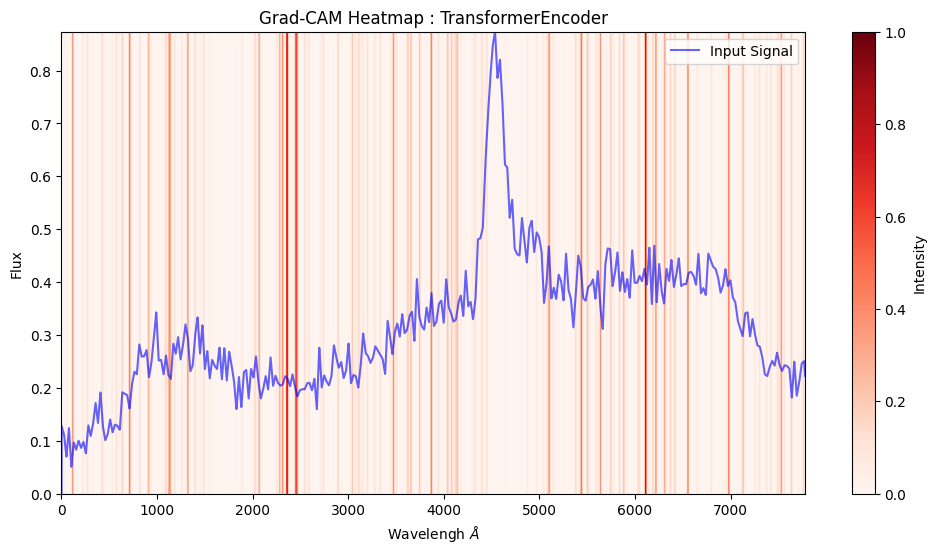

In [64]:
target_layer = model.transformer_encoder
grad_cam = GradCAM(model=model, target_layer=target_layer)

input_tensor = torch.tensor(test_df['flux'][1630]).unsqueeze(0).to(torch.float32)
input_tensor = input_tensor.to(accelerator.device)

# Generate Grad-CAM heatmap for a specific class or predicted class
heatmap = grad_cam.generate_cam(input_tensor)
print("Generated Heatmap Shape:", heatmap.shape)

target_layer_name = type(target_layer).__name__
visualize_heatmap(input_tensor, heatmap,target_layer_name)

## Custom GradCAM function for non conv layers

In [59]:
import torch
import torch.nn.functional as F

import torch
import torch.nn.functional as F

import torch
import torch.nn.functional as F

# criterion = NMADLoss(normalization_factor='std')
criterion = nn.MSELoss()


class GradCAM_MLP:
    def __init__(self, model, target_layer):
        """
        Initialize Grad-CAM for MLP layers.
        Args:
            model (nn.Module): The neural network model.
            target_layer (nn.Module): The layer to compute Grad-CAM on.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks to capture activations and gradients
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        """Save activations during forward pass."""
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        """Save gradients during backward pass."""
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor,additional_tensor, target_class=None):
        """
        Generate Grad-CAM heatmap for a given input tensor and target class.
        Args:
            input_tensor (torch.Tensor): Input tensor to the model.
            additional_data (torch.Tensor): Additional features tensor.
            target_class (int): Target class index. If None, use predicted class.

        Returns:
            heatmap (torch.Tensor): Generated heatmap.
        """
        # Forward pass through the model
        output = self.model(input_tensor,additional_tensor)

        # If no target class is specified, use the predicted class
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass to compute gradients of the target class score
        self.model.zero_grad()
        print(output, target_class)
        loss = criterion(output, target_class)
        # loss = output[output, target_class]  # Select score of the target class
        print(loss)
        # loss.backward()
        accelerator.backward(loss)

        # Get activations and gradients
        activations = self.activations  # Shape: [batch_size, seq_len, features]
        print(f'Activation Shape : {activations.shape}')
        gradients = self.gradients  # Shape: [batch_size, seq_len, features]
        print(f'Gradient Shape : {gradients.shape}')

        if activations.dim() == 2:
            activations = activations.unsqueeze(1)  # Shape: [batch_size, 1, embed_dim]
            gradients = gradients.unsqueeze(1)

        # Compute weights by global average pooling over sequence length
        weights = torch.mean(gradients, dim=1)  # Shape: [batch_size, features]

        # Compute weighted sum of activations
        # cam = torch.einsum("bse,be->bs", activations, weights)  # Shape: [batch_size, seq_len]

        # Apply ReLU and normalize
        cam = F.relu(weights)
        cam -= cam.min(dim=1, keepdim=True)[0]
        cam /= cam.max(dim=1, keepdim=True)[0] + 1e-8

        return cam





## Applying GradCam on Last prediction Linear Layer

tensor([[1.2039]], device='cuda:0', grad_fn=<SoftplusBackward0>) tensor([1.1900], device='cuda:0')
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
Activation Shape : torch.Size([1, 256])
Gradient Shape : torch.Size([1, 256])
Generated Heatmap Shape: torch.Size([1, 256])
(7781,)


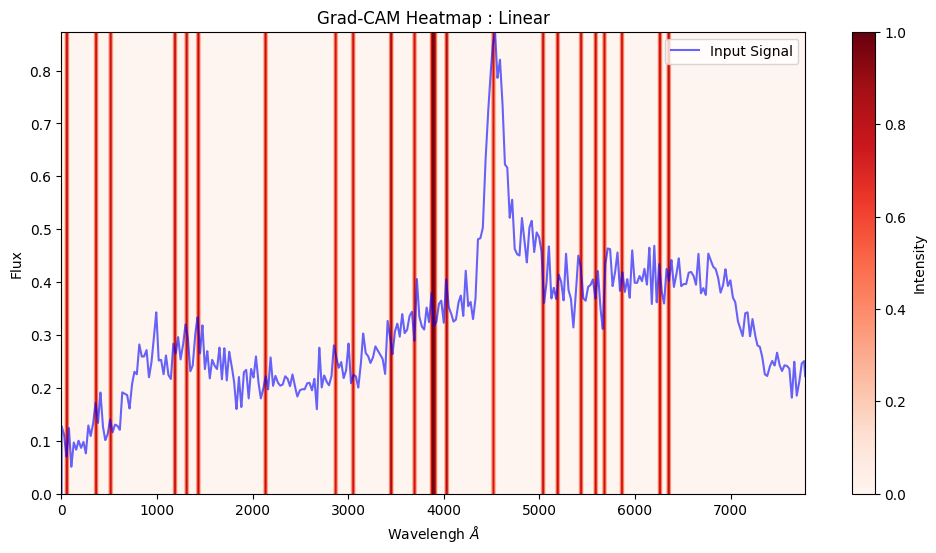

In [62]:
target_layer = redshift_model.prediction[0]
grad_cam = GradCAM_MLP(model=redshift_model, target_layer=target_layer)

input_tensor = torch.tensor(test_df['flux'][1630]).unsqueeze(0).to(torch.float32)
additional_tensor = torch.tensor(test_additional_data['flux'][1630]).unsqueeze(0).to(torch.float32)
target_tensor = torch.tensor(test_df['z'][1630]).unsqueeze(0).to(torch.float32)

input_tensor = input_tensor.to(accelerator.device)
target_tensor = target_tensor.to(accelerator.device)
additional_tensor = additional_tensor.to(accelerator.device)


# Generate Grad-CAM heatmap for a specific class or predicted class
heatmap = grad_cam.generate_cam(input_tensor,additional_tensor, target_tensor)
print("Generated Heatmap Shape:", heatmap.shape)
target_layer_name = type(target_layer).__name__
visualize_heatmap(input_tensor, heatmap,target_layer_name)
